In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns
from scipy.optimize import curve_fit
from collections import defaultdict

# 设置字体显示
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
def process_data(base_dir, sample_name, data_type, num_files=10):
    """
    处理单个数据类型的饱和曲线数据
    
    参数:
    base_dir: 数据目录路径
    sample_name: 样本名称
    data_type: 数据类型（用于显示）
    num_files: 文件数量
    
    返回:
    mean_counts: 平均累积数量
    mean_additions: 平均新增数量
    lower_bound_counts: 95%置信区间下界
    upper_bound_counts: 95%置信区间上界
    total_unique_combinations: 总唯一组合数
    """
    
    # 收集每个文件的序列集合
    file_sequences = {}
    
    # 从每个文件中提取loc和cdr3aa的联合特征
    print(f"正在提取{data_type}数据的loc_cdr3aa组合...")
    for part_num in range(num_files):
        contigs_file = os.path.join(base_dir, f"{sample_name}.part_{part_num:03d}.meta.gz")
        
        if not os.path.exists(contigs_file):
            print(f"警告: 找不到必需的文件: {contigs_file}")
            continue
        
        try:
            # 从meta文件中提取数据
            contigs_df = pd.read_csv(contigs_file, compression='gzip')
            
            # 筛选有效的loc和cdr3aa数据
            valid_df = contigs_df[(contigs_df['loc'].notna()) & (contigs_df['loc'] != 'region_not_covered') & 
                                 (contigs_df['cdr3aa'].notna()) & (contigs_df['cdr3aa'] != 'region_not_covered')]
            
            # 创建联合特征
            valid_df['loc_cdr3aa'] = valid_df['loc'] + "_" + valid_df['cdr3aa']
            
            # 获取唯一的联合特征集合
            unique_loc_cdr3aa = set(valid_df['loc_cdr3aa'])
            
            file_sequences[part_num] = unique_loc_cdr3aa
            print(f"{contigs_file} 包含 {len(unique_loc_cdr3aa)} 个唯一的loc_cdr3aa组合")
        except Exception as e:
            print(f"处理文件 {contigs_file} 时出错: {e}")
    
    # 计算所有文件中的唯一联合特征总数
    all_combinations = set()
    for combos in file_sequences.values():
        all_combinations.update(combos)
    total_unique_combinations = len(all_combinations)
    print(f"{data_type}所有文件中的唯一loc_cdr3aa组合总数: {total_unique_combinations}")
    
    # 获取可能的文件添加顺序（使用100个随机排列以提高效率）
    all_file_indices = list(file_sequences.keys())
    if len(all_file_indices) > 8:  # 如果文件太多，随机抽样排列
        import random
        all_permutations = []
        for _ in range(100):
            all_permutations.append(random.sample(all_file_indices, len(all_file_indices)))
    else:
        all_permutations = list(itertools.permutations(all_file_indices))
    
    # 存储不同排列下的累积序列数和新增序列数
    all_cumulative_counts = []
    all_new_additions = []
    
    # 分析每一种可能的排列顺序
    for perm in all_permutations:
        perm_accumulation = [0]  # 从0开始
        perm_additions = []      # 新增数量
        current_sequences = set()
        
        for idx in perm:
            new_sequences = file_sequences[idx]
            # 找出新增的序列
            new_additions = new_sequences - current_sequences
            perm_additions.append(len(new_additions))
            
            # 更新当前序列集合
            current_sequences.update(new_additions)
            
            # 计算累积数量
            current_count = len(current_sequences)
            perm_accumulation.append(current_count)
        
        all_cumulative_counts.append(perm_accumulation)
        all_new_additions.append(perm_additions)
    
    # 转换为NumPy数组方便计算
    all_cumulative_counts = np.array(all_cumulative_counts)
    all_new_additions = np.array(all_new_additions)
    
    # 计算平均值和95%置信区间
    mean_counts = np.mean(all_cumulative_counts, axis=0)
    mean_additions = np.mean(all_new_additions, axis=0)
    lower_bound_counts = np.percentile(all_cumulative_counts, 2.5, axis=0)
    upper_bound_counts = np.percentile(all_cumulative_counts, 97.5, axis=0)
    
    
    
    return mean_counts, mean_additions, lower_bound_counts, upper_bound_counts, total_unique_combinations

In [3]:
def calculate_diversity(cyclone_dir=None, ngs_dir=None, sample_name=None, num_files=10):
    """
    逐步添加文件并计算cdr3aa多样性
    
    参数:
    cyclone_dir: Cyclone数据目录路径
    ngs_dir: NGS数据目录路径
    sample_name: 样本名称
    num_files: 要处理的文件数量
    
    返回:
    cyclone_avgs: 每一步的Cyclone文件中cdr3aa平均种类数量列表
    sge_avgs: 每一步的SGE文件中cdr3aa平均种类数量列表
    common_locs_counts: 每一步的共有loc数量列表
    """
    print("逐步添加文件并计算cdr3aa多样性...\n")
    
    # 用于累积每个loc下的cdr3aa集合
    cyclone_all_data = defaultdict(set)
    sge_all_data = defaultdict(set)
    
    # 存储结果
    cyclone_avgs = []
    sge_avgs = []
    common_locs_counts = []
    
    for part_num in range(num_files):
        print(f"添加第 {part_num+1} 份数据 (part_{part_num:03d})...")
        
        # 读取文件
        cyclone_file = os.path.join(cyclone_dir, f"{sample_name}.part_{part_num:03d}.meta.gz")
        sge_file = os.path.join(ngs_dir, f"{sample_name}.part_{part_num:03d}.meta.gz")
        
        try:
            cyclone_df = pd.read_csv(cyclone_file, compression='gzip')
            sge_df = pd.read_csv(sge_file, compression='gzip')
            
            # 筛选有效的loc和cdr3aa数据
            cyclone_valid = cyclone_df[(cyclone_df['loc'].notna()) & 
                                      (cyclone_df['loc'] != 'region_not_covered') & 
                                      (cyclone_df['cdr3aa'].notna()) & 
                                      (cyclone_df['cdr3aa'] != 'region_not_covered')]
            
            sge_valid = sge_df[(sge_df['loc'].notna()) & 
                              (sge_df['loc'] != 'region_not_covered') & 
                              (sge_df['cdr3aa'].notna()) & 
                              (sge_df['cdr3aa'] != 'region_not_covered')]
            
            # 累加到集合
            for _, row in cyclone_valid.iterrows():
                cyclone_all_data[row['loc']].add(row['cdr3aa'])
            for _, row in sge_valid.iterrows():
                sge_all_data[row['loc']].add(row['cdr3aa'])
            
            # 获取共有的loc
            cyclone_locs = set(cyclone_all_data.keys())
            sge_locs = set(sge_all_data.keys())
            common_locs = cyclone_locs & sge_locs
            
            # 计算每个共有loc下的cdr3aa平均种类数量
            cyclone_avg = np.mean([len(cyclone_all_data[loc]) for loc in common_locs]) if common_locs else 0
            sge_avg = np.mean([len(sge_all_data[loc]) for loc in common_locs]) if common_locs else 0
            
            # 保存结果
            cyclone_avgs.append(cyclone_avg)
            sge_avgs.append(sge_avg)
            common_locs_counts.append(len(common_locs))
            
            print(f"{part_num+1}份Cyclone文件中共有loc的cdr3aa平均种类数量: {cyclone_avg:.2f}")
            print(f"{part_num+1}份SGE文件中共有loc的cdr3aa平均种类数量: {sge_avg:.2f}")
            print(f"共有loc数量: {len(common_locs)}")
            print("------")
            
        except Exception as e:
            print(f"处理第 {part_num+1} 份数据时出错: {e}")
            # 保持数组长度一致，出错时使用前一个值或0
            cyclone_avgs.append(cyclone_avgs[-1] if cyclone_avgs else 0)
            sge_avgs.append(sge_avgs[-1] if sge_avgs else 0)
            common_locs_counts.append(common_locs_counts[-1] if common_locs_counts else 0)
    
    return cyclone_avgs, sge_avgs, common_locs_counts

In [4]:
def calculate_non_functional_ratio(cyclone_dir=None, ngs_dir=None, sample_name=None, num_files=10):
    """
    逐步添加文件并计算每个loc下Non-functional的比例
    
    参数:
    cyclone_dir: Cyclone数据目录路径
    ngs_dir: NGS数据目录路径
    sample_name: 样本名称
    num_files: 要处理的文件数量
    
    返回:
    cyclone_ratios_list: 每个数据量下所有loc的Non-functional比例列表
    ngs_ratios_list: 每个数据量下所有loc的Non-functional比例列表
    """
    print("逐步添加文件并计算Non-functional比例...\n")
    
    # 用于累积每个loc下的序列情况
    cyclone_func_count = defaultdict(int)
    cyclone_non_func_count = defaultdict(int)
    ngs_func_count = defaultdict(int)
    ngs_non_func_count = defaultdict(int)
    
    # 存储每个数据量下的所有loc的比例
    cyclone_ratios_list = []
    ngs_ratios_list = []
    
    # 用于存储每次添加文件后的比例数据
    cyclone_ratio_data = []
    ngs_ratio_data = []
    
    for part_num in range(num_files):
        print(f"添加第 {part_num+1} 份数据 (part_{part_num:03d})...")
        
        # 读取文件
        cyclone_file = os.path.join(cyclone_dir, f"{sample_name}.part_{part_num:03d}.meta.gz")
        ngs_file = os.path.join(ngs_dir, f"{sample_name}.part_{part_num:03d}.meta.gz")
        
        try:
            cyclone_df = pd.read_csv(cyclone_file, compression='gzip')
            ngs_df = pd.read_csv(ngs_file, compression='gzip')
            
            # 筛选有效的loc数据
            cyclone_valid = cyclone_df[(cyclone_df['loc'].notna()) & 
                                      (cyclone_df['loc'] != 'region_not_covered')]
            
            ngs_valid = ngs_df[(ngs_df['loc'].notna()) & 
                              (ngs_df['loc'] != 'region_not_covered')]
            
            # 累加到统计
            for _, row in cyclone_valid.iterrows():
                if row['func'] == 'Non-functional':
                    cyclone_non_func_count[row['loc']] += 1
                elif row['func'] == 'Functional':
                    cyclone_func_count[row['loc']] += 1
            
            for _, row in ngs_valid.iterrows():
                if row['func'] == 'Non-functional':
                    ngs_non_func_count[row['loc']] += 1
                elif row['func'] == 'Functional':
                    ngs_func_count[row['loc']] += 1
            
            # 计算每个loc的Non-functional比例
            cyclone_ratios = {}
            ngs_ratios = {}
            
            for loc in set(list(cyclone_func_count.keys()) + list(cyclone_non_func_count.keys())):
                total = cyclone_func_count[loc] + cyclone_non_func_count[loc]
                if total > 0:
                    cyclone_ratios[loc] = cyclone_non_func_count[loc] / total
            
            for loc in set(list(ngs_func_count.keys()) + list(ngs_non_func_count.keys())):
                total = ngs_func_count[loc] + ngs_non_func_count[loc]
                if total > 0:
                    ngs_ratios[loc] = ngs_non_func_count[loc] / total
            
            # 将比例数据保存为DataFrame
            cyclone_df_ratio = pd.DataFrame({
                'loc': list(cyclone_ratios.keys()),
                'Non-functional-proportion': list(cyclone_ratios.values())
            })
            
            ngs_df_ratio = pd.DataFrame({
                'loc': list(ngs_ratios.keys()),
                'Non-functional-proportion': list(ngs_ratios.values())
            })
            
            # 保存当前比例数据
            cyclone_ratio_data.append(cyclone_df_ratio)
            ngs_ratio_data.append(ngs_df_ratio)
            
            # 添加到列表，用于后续boxplot
            cyclone_ratios_list.append(list(cyclone_ratios.values()))
            ngs_ratios_list.append(list(ngs_ratios.values()))
            
            # 输出一些统计信息
            print(f"{part_num+1}份Cyclone文件中统计的loc数量: {len(cyclone_ratios)}")
            print(f"{part_num+1}份NGS文件中统计的loc数量: {len(ngs_ratios)}")
            
            # 计算平均Non-functional比例
            cyclone_avg_ratio = np.mean(list(cyclone_ratios.values())) if cyclone_ratios else 0
            ngs_avg_ratio = np.mean(list(ngs_ratios.values())) if ngs_ratios else 0
            
            print(f"Cyclone平均Non-functional比例: {cyclone_avg_ratio:.4f}")
            print(f"NGS平均Non-functional比例: {ngs_avg_ratio:.4f}")
            print("------")
            
        except Exception as e:
            print(f"处理第 {part_num+1} 份数据时出错: {e}")
            # 出错时使用前一个值或空列表
            cyclone_ratios_list.append(cyclone_ratios_list[-1] if cyclone_ratios_list else [])
            ngs_ratios_list.append(ngs_ratios_list[-1] if ngs_ratios_list else [])
    
    return cyclone_ratios_list, ngs_ratios_list, cyclone_ratio_data, ngs_ratio_data

In [5]:
def calculate_overall_non_functional_ratio(cyclone_dir=None, ngs_dir=None, sample_name=None, num_files=10):
    """
    计算每份文件的总体Non-functional比例
    
    参数:
    cyclone_dir: Cyclone数据目录路径
    ngs_dir: NGS数据目录路径
    sample_name: 样本名称
    num_files: 要处理的文件数量
    
    返回:
    cyclone_overall_ratios: Cyclone每份文件的Non-functional总体比例
    ngs_overall_ratios: NGS每份文件的Non-functional总体比例
    """
    print("计算每份文件的总体Non-functional比例...\n")
    
    # 存储每份文件的总体比例
    cyclone_overall_ratios = []
    ngs_overall_ratios = []
    
    for part_num in range(num_files):
        print(f"处理第 {part_num+1} 份数据 (part_{part_num:03d})...")
        
        # 读取文件
        cyclone_file = os.path.join(cyclone_dir, f"{sample_name}.part_{part_num:03d}.meta.gz")
        ngs_file = os.path.join(ngs_dir, f"{sample_name}.part_{part_num:03d}.meta.gz")
        
        try:
            cyclone_df = pd.read_csv(cyclone_file, compression='gzip')
            ngs_df = pd.read_csv(ngs_file, compression='gzip')
            
            # 筛选有效的数据
            cyclone_valid = cyclone_df[(cyclone_df['loc'].notna()) & 
                                     (cyclone_df['loc'] != 'region_not_covered')]
            
            ngs_valid = ngs_df[(ngs_df['loc'].notna()) & 
                              (ngs_df['loc'] != 'region_not_covered')]
            
            # 计算Cyclone文件的Non-functional比例
            cyclone_non_func_count = sum(cyclone_valid['func'] == 'Non-functional')
            cyclone_total_count = len(cyclone_valid)
            cyclone_ratio = cyclone_non_func_count / cyclone_total_count if cyclone_total_count > 0 else 0
            cyclone_overall_ratios.append(cyclone_ratio)
            
            # 计算NGS文件的Non-functional比例
            ngs_non_func_count = sum(ngs_valid['func'] == 'Non-functional')
            ngs_total_count = len(ngs_valid)
            ngs_ratio = ngs_non_func_count / ngs_total_count if ngs_total_count > 0 else 0
            ngs_overall_ratios.append(ngs_ratio)
            
            print(f"Cyclone文件总体Non-functional比例: {cyclone_ratio:.4f}")
            print(f"NGS文件总体Non-functional比例: {ngs_ratio:.4f}")
            print("------")
            
        except Exception as e:
            print(f"处理第 {part_num+1} 份数据时出错: {e}")
            # 出错时使用前一个值或0
            cyclone_overall_ratios.append(cyclone_overall_ratios[-1] if cyclone_overall_ratios else 0)
            ngs_overall_ratios.append(ngs_overall_ratios[-1] if ngs_overall_ratios else 0)
    
    return cyclone_overall_ratios, ngs_overall_ratios

In [6]:
# 定义数据路径
cyclone_dir = "/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/cyclone/meta/random_split"
ngs_dir = "/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/sge/meta/random_split"
sample_name = "7-ZXH_LC"
num_files = 10  # 总共10个文件(part_000到part_009)

In [7]:
# 处理Cyclone数据
cyclone_mean, cyclone_additions, cyclone_lower, cyclone_upper, cyclone_total = process_data(
    cyclone_dir, sample_name, "Cyclone", num_files)

# 处理NGS数据
ngs_mean, ngs_additions, ngs_lower, ngs_upper, ngs_total = process_data(
    ngs_dir, sample_name, "NGS", num_files)

正在提取Cyclone数据的loc_cdr3aa组合...
/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/cyclone/meta/random_split/7-ZXH_LC.part_000.meta.gz 包含 18745 个唯一的loc_cdr3aa组合
/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/cyclone/meta/random_split/7-ZXH_LC.part_001.meta.gz 包含 18541 个唯一的loc_cdr3aa组合
/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/cyclone/meta/random_split/7-ZXH_LC.part_002.meta.gz 包含 18533 个唯一的loc_cdr3aa组合
/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/cyclone/meta/random_split/7-ZXH_LC.part_003.meta.gz 包含 18607 个唯一的loc_cdr3aa组合
/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/cyclone/meta/random_split/7-ZXH_LC.part_004.meta.gz 包含 18516 个唯一的loc_cdr3aa组合
/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/saturation_curve/7-ZXH_LC/cyclone/meta/random_split/7-ZXH_LC.part_005.meta.gz 包含 18690 个唯一的loc_cdr3aa组合
/home/zhanxiaojuan/data1/zhanxiaojuan/PRCA033509/sat

In [8]:
cyclone_avgs, sge_avgs, common_locs_counts = calculate_diversity(
    cyclone_dir=cyclone_dir, 
    ngs_dir=ngs_dir, 
    sample_name=sample_name, 
    num_files=10
)

逐步添加文件并计算cdr3aa多样性...

添加第 1 份数据 (part_000)...
1份Cyclone文件中共有loc的cdr3aa平均种类数量: 3.63
1份SGE文件中共有loc的cdr3aa平均种类数量: 1.86
共有loc数量: 1080
------
添加第 2 份数据 (part_001)...
2份Cyclone文件中共有loc的cdr3aa平均种类数量: 4.40
2份SGE文件中共有loc的cdr3aa平均种类数量: 2.05
共有loc数量: 2266
------
添加第 3 份数据 (part_002)...
3份Cyclone文件中共有loc的cdr3aa平均种类数量: 4.70
3份SGE文件中共有loc的cdr3aa平均种类数量: 2.20
共有loc数量: 3519
------
添加第 4 份数据 (part_003)...
4份Cyclone文件中共有loc的cdr3aa平均种类数量: 5.02
4份SGE文件中共有loc的cdr3aa平均种类数量: 2.26
共有loc数量: 4720
------
添加第 5 份数据 (part_004)...
5份Cyclone文件中共有loc的cdr3aa平均种类数量: 5.18
5份SGE文件中共有loc的cdr3aa平均种类数量: 2.27
共有loc数量: 6039
------
添加第 6 份数据 (part_005)...
6份Cyclone文件中共有loc的cdr3aa平均种类数量: 5.31
6份SGE文件中共有loc的cdr3aa平均种类数量: 2.28
共有loc数量: 7373
------
添加第 7 份数据 (part_006)...
7份Cyclone文件中共有loc的cdr3aa平均种类数量: 5.42
7份SGE文件中共有loc的cdr3aa平均种类数量: 2.29
共有loc数量: 8707
------
添加第 8 份数据 (part_007)...
8份Cyclone文件中共有loc的cdr3aa平均种类数量: 5.55
8份SGE文件中共有loc的cdr3aa平均种类数量: 2.29
共有loc数量: 10096
------
添加第 9 份数据 (part_008)...
9份Cyclone文件中共有loc的cdr3aa平均种类数量: 

In [9]:
# 调用函数计算Non-functional比例
cyclone_ratios_list, ngs_ratios_list, cyclone_ratio_data, ngs_ratio_data = calculate_non_functional_ratio(
    cyclone_dir=cyclone_dir, 
    ngs_dir=ngs_dir, 
    sample_name=sample_name, 
    num_files=10
)

逐步添加文件并计算Non-functional比例...

添加第 1 份数据 (part_000)...
1份Cyclone文件中统计的loc数量: 10110
1份NGS文件中统计的loc数量: 3067
Cyclone平均Non-functional比例: 0.3483
NGS平均Non-functional比例: 0.0217
------
添加第 2 份数据 (part_001)...
2份Cyclone文件中统计的loc数量: 16524
2份NGS文件中统计的loc数量: 4894
Cyclone平均Non-functional比例: 0.3315
NGS平均Non-functional比例: 0.0175
------
添加第 3 份数据 (part_002)...
3份Cyclone文件中统计的loc数量: 21862
3份NGS文件中统计的loc数量: 6409
Cyclone平均Non-functional比例: 0.3273
NGS平均Non-functional比例: 0.0171
------
添加第 4 份数据 (part_003)...
4份Cyclone文件中统计的loc数量: 26422
4份NGS文件中统计的loc数量: 7659
Cyclone平均Non-functional比例: 0.3218
NGS平均Non-functional比例: 0.0174
------
添加第 5 份数据 (part_004)...
5份Cyclone文件中统计的loc数量: 30503
5份NGS文件中统计的loc数量: 8919
Cyclone平均Non-functional比例: 0.3195
NGS平均Non-functional比例: 0.0177
------
添加第 6 份数据 (part_005)...
6份Cyclone文件中统计的loc数量: 34148
6份NGS文件中统计的loc数量: 9981
Cyclone平均Non-functional比例: 0.3169
NGS平均Non-functional比例: 0.0166
------
添加第 7 份数据 (part_006)...
7份Cyclone文件中统计的loc数量: 37333
7份NGS文件中统计的loc数量: 11020
Cyclone平均Non-funct

In [10]:
cyclone_overall_ratios, ngs_overall_ratios = calculate_overall_non_functional_ratio(
    cyclone_dir=cyclone_dir, 
    ngs_dir=ngs_dir, 
    sample_name=sample_name, 
    num_files=10
)

计算每份文件的总体Non-functional比例...

处理第 1 份数据 (part_000)...
Cyclone文件总体Non-functional比例: 0.4054
NGS文件总体Non-functional比例: 0.0683
------
处理第 2 份数据 (part_001)...
Cyclone文件总体Non-functional比例: 0.3955
NGS文件总体Non-functional比例: 0.0675
------
处理第 3 份数据 (part_002)...
Cyclone文件总体Non-functional比例: 0.3949
NGS文件总体Non-functional比例: 0.0694
------
处理第 4 份数据 (part_003)...
Cyclone文件总体Non-functional比例: 0.4021
NGS文件总体Non-functional比例: 0.0703
------
处理第 5 份数据 (part_004)...
Cyclone文件总体Non-functional比例: 0.3994
NGS文件总体Non-functional比例: 0.0712
------
处理第 6 份数据 (part_005)...
Cyclone文件总体Non-functional比例: 0.4010
NGS文件总体Non-functional比例: 0.0691
------
处理第 7 份数据 (part_006)...
Cyclone文件总体Non-functional比例: 0.3980
NGS文件总体Non-functional比例: 0.0687
------
处理第 8 份数据 (part_007)...
Cyclone文件总体Non-functional比例: 0.3952
NGS文件总体Non-functional比例: 0.0674
------
处理第 9 份数据 (part_008)...
Cyclone文件总体Non-functional比例: 0.3974
NGS文件总体Non-functional比例: 0.0679
------
处理第 10 份数据 (part_009)...
Cyclone文件总体Non-functional比例: 0.4023
NGS文件总体Non-functio

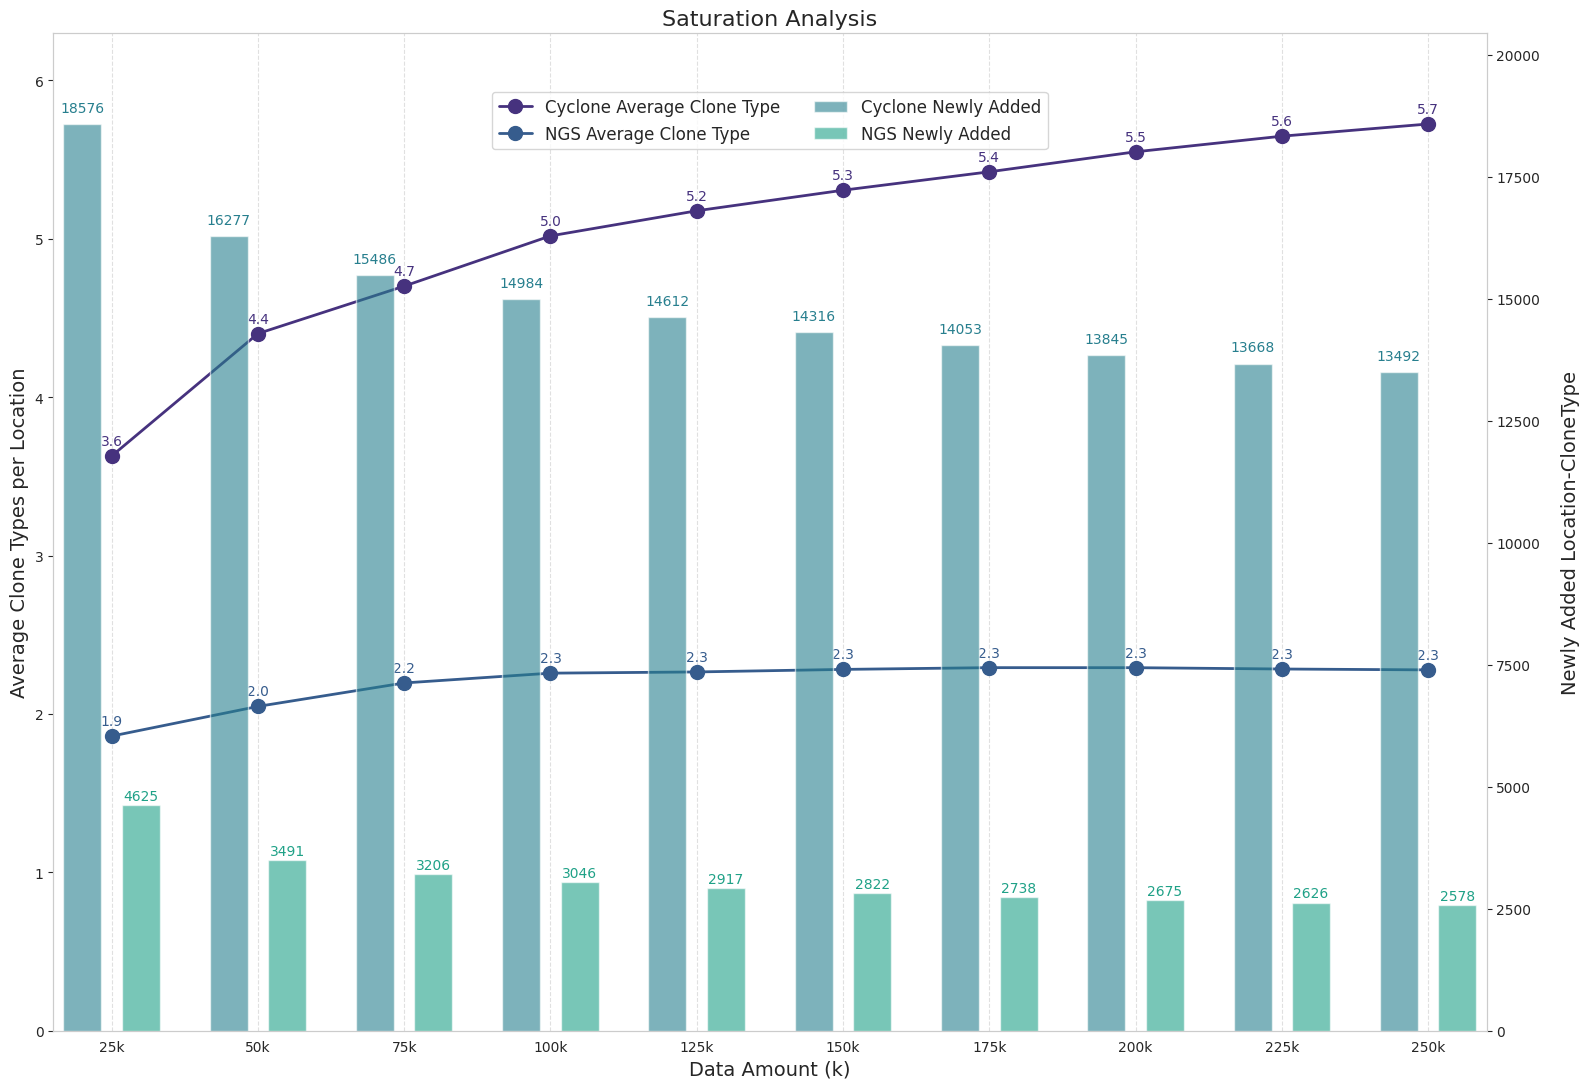

In [15]:
# 创建横坐标：数据量从25k到250k
data_amounts = np.array([25, 50, 75, 100, 125, 150, 175, 200, 225, 250])  # 单位：k

# 绘制饱和曲线（多y轴，显示各项指标）
plt.figure(figsize=(16, 11))  # 增加图表高度

# 设置样式
sns.set_style("whitegrid")
colors = sns.color_palette("viridis", 6)

# 创建第一个y轴：CDR3AA多样性
ax1 = plt.gca()

# 绘制Cyclone cdr3aa平均多样性曲线
ax1.plot(data_amounts, cyclone_avgs, marker='o', markersize=10, linewidth=2, color=colors[0], 
         label='Cyclone Average Clone Type')

# 绘制SGE cdr3aa平均多样性曲线
ax1.plot(data_amounts, sge_avgs, marker='o', markersize=10, linewidth=2, color=colors[1], 
         label='NGS Average Clone Type')

# 绘制Cyclone新增联合特征数量的柱状图
bar_positions_cyclone = data_amounts - 5.0  # 调整位置
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.0))
ax3.bar(bar_positions_cyclone, cyclone_additions, alpha=0.6, color=colors[2], width=6.5,
        label='Cyclone Newly Added')

# 绘制NGS新增联合特征数量的柱状图
bar_positions_ngs = data_amounts + 5.0  # 调整位置
ax3.bar(bar_positions_ngs, ngs_additions, alpha=0.6, color=colors[3], width=6.5,
        label='NGS Newly Added')

# 设置标签和标题
ax1.set_xlabel('Data Amount (k)', fontsize=14)
ax1.set_ylabel('Average Clone Types per Location', fontsize=14)
ax3.set_ylabel('Newly Added Location-CloneType', fontsize=14, labelpad=15)
plt.title('Saturation Analysis', fontsize=16)

# 设置x轴刻度
plt.xticks(data_amounts, [f'{int(x)}k' for x in data_amounts])

# 组合多个图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines3, labels1 + labels3, 
           loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=12, ncol=2)

# 为CDR3AA多样性曲线添加文本注释
for i, amount in enumerate(data_amounts):
    ax1.text(amount, cyclone_avgs[i] + 0.05, f'{cyclone_avgs[i]:.1f}', 
             ha='center', va='bottom', fontsize=10, color=colors[0])
    ax1.text(amount, sge_avgs[i] + 0.05, f'{sge_avgs[i]:.1f}', 
             ha='center', va='bottom', fontsize=10, color=colors[1])

# 添加文本注释：Cyclone新增联合特征数量
for i, amount in enumerate(data_amounts):
    ax3.text(bar_positions_cyclone[i], cyclone_additions[i] + max(cyclone_additions)*0.01, 
            f'{int(cyclone_additions[i])}', 
            ha='center', va='bottom', fontsize=10, color=colors[2])

# 添加文本注释：NGS新增联合特征数量
for i, amount in enumerate(data_amounts):
    ax3.text(bar_positions_ngs[i], ngs_additions[i] + max(ngs_additions)*0.01, 
            f'{int(ngs_additions[i])}', 
            ha='center', va='bottom', fontsize=10, color=colors[3])

# 设置y轴范围 - 根据平均克隆类型数据调整
max_avg = max(max(cyclone_avgs), max(sge_avgs))
ax1.set_ylim(0, max_avg * 1.1)  # 为文本注释留出空间
max_additions = max(max(cyclone_additions), max(ngs_additions))
ax3.set_ylim(0, max_additions * 1.1)

# 设置x轴范围
plt.xlim(15, 260)  # 调整范围以适应更宽的柱状图和文本

# 添加网格线
ax1.grid(False)
ax3.grid(False)
ax1.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('Saturation.pdf', dpi=600, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2011341/127957932.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box1 = ax1.boxplot(boxplot_data, patch_artist=True, labels=labels, widths=0.5)
/tmp/ipykernel_2011341/127957932.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box2 = ax2.boxplot(boxplot_data, patch_artist=True, labels=labels, widths=0.5)
/tmp/ipykernel_2011341/127957932.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


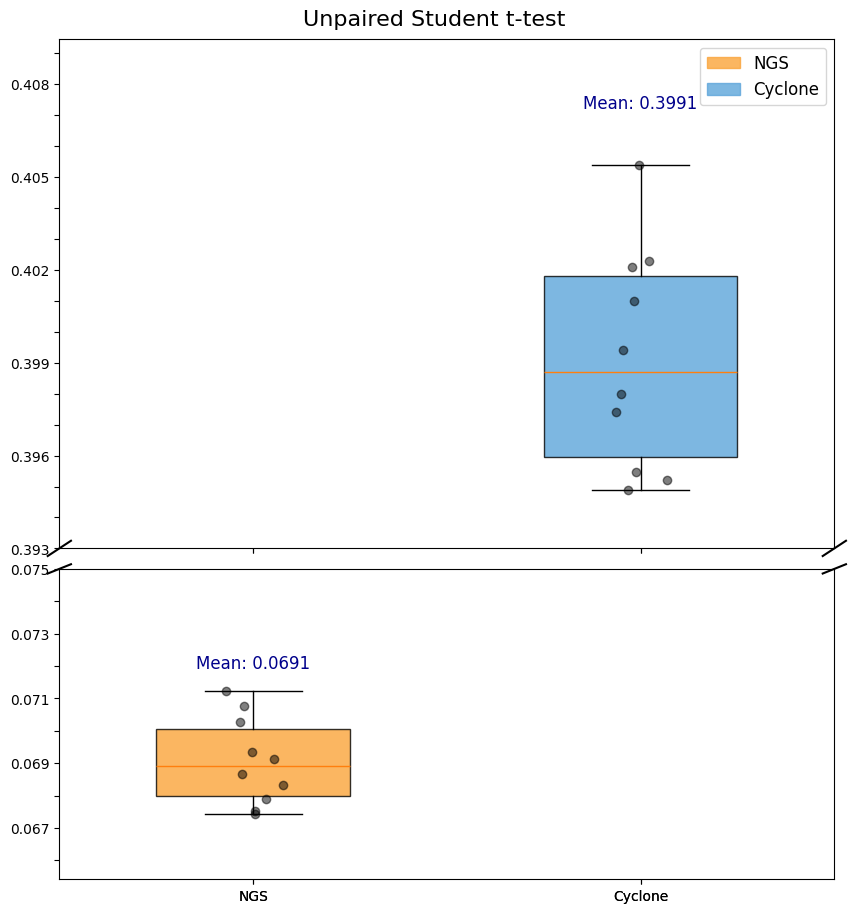

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

# 交换数据顺序，使NGS在左，Cyclone在右
boxplot_data = [ngs_overall_ratios, cyclone_overall_ratios]  # 顺序交换
labels = ['NGS', 'Cyclone']  # 顺序交换

# 设置指定的颜色
colors = ['#FAA43A', '#5DA5DA']  # NGS颜色为FAA43A，Cyclone颜色为5DA5DA

# 设置区间参数
top_min = 0.393    # 上部分图表的最小值
bottom_max = 0.075  # 下部分图表的最大值

# 计算数据范围
max_val = max([max(data) for data in boxplot_data])
min_val = min([min(data) for data in boxplot_data])

# 计算上下部分需要显示的数据单位数
top_units = (max_val - top_min) / 0.001  # 每0.001作为一个单位
bottom_units = (bottom_max - min_val) / 0.001

# 根据单位数计算高度比例，确保每个0.001的数据范围有相同的视觉高度
height_ratios = [top_units, bottom_units]

# 创建带有计算出的比例的子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, 
                               gridspec_kw={'height_ratios': height_ratios, 'hspace': 0.05})

# 在两个子图上绘制箱线图
box1 = ax1.boxplot(boxplot_data, patch_artist=True, labels=labels, widths=0.5)
box2 = ax2.boxplot(boxplot_data, patch_artist=True, labels=labels, widths=0.5)

# 设置颜色
for i, patch in enumerate(box1['boxes']):
    patch.set_facecolor(colors[i])
    patch.set_alpha(0.8)
    
for i, patch in enumerate(box2['boxes']):
    patch.set_facecolor(colors[i])
    patch.set_alpha(0.8)

# 添加数据点
for i, data in enumerate(boxplot_data):
    # 上部分的点
    top_data = [d for d in data if d >= top_min]
    if top_data:
        x = np.random.normal(i+1, 0.04, size=len(top_data))
        ax1.plot(x, top_data, 'o', color='black', alpha=0.5)
    
    # 下部分的点
    bottom_data = [d for d in data if d <= bottom_max]
    if bottom_data:
        x = np.random.normal(i+1, 0.04, size=len(bottom_data))
        ax2.plot(x, bottom_data, 'o', color='black', alpha=0.5)

# 设置精确的y轴范围
ax1.set_ylim(top_min, max_val * 1.01)
ax2.set_ylim(min_val * 0.97, bottom_max)

# 设置刻度间距为0.001
def set_ticks_by_unit(ax, min_val, max_val, unit=0.001):
    """设置刻度，使每个刻度间隔为指定单位"""
    # 向下取整到最接近的单位
    start = np.floor(min_val / unit) * unit
    # 向上取整到最接近的单位
    end = np.ceil(max_val / unit) * unit
    # 生成刻度点
    ticks = np.arange(start, end + unit/2, unit)
    ax.yaxis.set_major_locator(ticker.FixedLocator(ticks))
    # 设置格式，显示较少的刻度标签以避免拥挤
    if len(ticks) > 10:
        step = len(ticks) // 10 + 1
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda x, pos: f'{x:.3f}' if pos % step == 0 else ''))
    else:
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

# 应用刻度设置
set_ticks_by_unit(ax1, top_min, max_val * 1.03)
set_ticks_by_unit(ax2, min_val * 0.97, bottom_max)

ax1.grid(False)
ax2.grid(False)

# 添加标题和标签
fig.suptitle('Unpaired Student t-test', fontsize=16)
ax2.set_xlabel('')

# 添加平均值文本标注
for i, data in enumerate(boxplot_data):
    avg = np.mean(data)
    # 根据均值位置决定在哪个子图添加文本
    if avg >= top_min:
        ax1.text(i+1, avg * 1.02, f'Mean: {avg:.4f}', 
                ha='center', va='bottom', fontsize=12, color='darkblue')
    else:
        ax2.text(i+1, avg * 1.04, f'Mean: {avg:.4f}', 
                ha='center', va='bottom', fontsize=12, color='darkblue')

# 添加断裂标记
d = .015  # 断裂标记的大小
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # 下左
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # 下右

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # 上左
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # 上右

# 添加图例（顺序与数据顺序一致）
ngs_patch = mpatches.Patch(color=colors[0], alpha=0.8, label='NGS')
cyclone_patch = mpatches.Patch(color=colors[1], alpha=0.8, label='Cyclone')
ax1.legend(handles=[ngs_patch, cyclone_patch], fontsize=12)

plt.savefig('unpaired_student_t_test.pdf', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.subplots_adjust(top=0.95) # 为标题腾出空间
plt.show()